In [1]:
import os
from utils import read_input_raster_data_to_np, read_input_raster_data_to_np_buildings, read_input_raster_data
import numpy as np
from osgeo import gdal, ogr, osr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio.crs import CRS
from utils import plot_2dmatrix
import shutil


In [97]:

root_paths = ["/scratch3/ldominiak/luca_pomelo_input_data/"]

for dir in root_paths:
    if os.path.isdir(dir):
        root_path = dir

In [98]:
input_paths = {
    "che": {
        "buildings_switzerland_WEST": f"{root_path}CHE/CHE_TLM/TLM_BAUTEN/swissTLM3D_TLM_GEBAEUDE_FOOTPRINT_WEST.shp", 
        "buildings_switzerland_OST": f"{root_path}CHE/CHE_TLM/TLM_BAUTEN/swissTLM3D_TLM_GEBAEUDE_FOOTPRINT_OST.shp"
    }

}

In [87]:
def get_tiff_from_shp(input_paths, country_name):

    merged_shp = 0

    for key in input_paths[country_name]:
        path = input_paths[country_name][key]
        shp = gpd.read_file(path)

        merged_shp = gpd.GeoDataFrame(pd.concat([shp, merged_shp]), ignore_index=True)

        print(merged_shp)



        

In [32]:
shp1 = gpd.read_file(input_paths["che"]["buildings_switzerland_WEST"])
shp2 = gpd.read_file(input_paths["che"]["buildings_switzerland_OST"])

### Reading the west and the east part of switzerland; both 1 gb, takes forever


In [33]:
merged_shp = gpd.GeoDataFrame(pd.concat([shp1, shp2]))

### Merging them into one shape file


In [34]:
fields_to_delete = ['DATUM_AEND','DATUM_ERST','ERSTELL_J','ERSTELL_M','REVISION_J','REVISION_M','GRUND_AEND','HERKUNFT','HERKUNFT_J',
                    'HERKUNFT_M','OBJEKTART','REVISION_Q','BAU_NAME_U','NAME','NUTZUNG']

merged_shp.drop(fields_to_delete, axis=1, inplace=True)
### Droping all unnecessary columns for faster oeprations

In [35]:
merged_shp = merged_shp.to_crs(4326)

### Changing the CRS to wgs84

In [36]:
merged_shp.to_file("/scratch3/ldominiak/luca_pomelo_input_data/CHE/merged_CHE.shp")

### merged file saved to directory

In [99]:
used_shp = ogr.Open("/scratch3/ldominiak/luca_pomelo_input_data/CHE/merged_CHE.shp")
source_layer = used_shp.GetLayer()
defn = source_layer.GetLayerDefn()

###ab hier brauchen
### CRS ändern

In [193]:

column_names = []

for n in range(defn.GetFieldCount()):
    fdefn = defn.GetFieldDefn(n)
    column_names.append(fdefn.name)

In [195]:
column_names[0]

'UUID'

In [196]:
Output_raster_location = "/scratch3/ldominiak/luca_pomelo_input_data/CHE/merged_CHE.tif"
pixel_size = 0.00083333333  #0.000009056 degrees/meter

path = "/scratch3/ldominiak/luca_pomelo_input_data/CHE/CHE_Covariates/che_dst_bsgme_100m_2015.tif"
with rio.open(path) as src:
    # read the spatial information
    left, bottom, right, top = src.bounds
print(left, right, top, bottom)

5.956249991169982 10.495416639679982 47.81458334344999 45.81708335143999


In [197]:
x_res = int(round((right - left) / pixel_size))
y_res = int(round((top - bottom) / pixel_size))
print(x_res)
print(y_res)

5447
2397


In [198]:
target_ds = gdal.GetDriverByName('GTiff').Create(Output_raster_location, x_res, y_res, 1, gdal.GDT_Float32, ["COMPRESS=LZW"])
target_ds.SetGeoTransform((left, pixel_size, 0.0, top, 0.0, -pixel_size))
srse = osr.SpatialReference()
proj = 'EPSG:4326'
srse.SetWellKnownGeogCS(proj)
target_ds.SetProjection(srse.ExportToWkt())
band = target_ds.GetRasterBand(1)
target_ds.GetRasterBand(1).SetNoDataValue(-99999)
band.Fill(-99999)
gdal.RasterizeLayer(target_ds, [1], source_layer, None, None, [1], options = ['ALL_TOUCHED=TRUE, ATTRITURE=column_names[0]'])
target_ds = None

In [199]:
data_set = gdal.Open("/scratch3/ldominiak/luca_pomelo_input_data/CHE/merged_CHE.tif")
band_1 = data_set.GetRasterBand(1)
b1 = band_1.ReadAsArray() 

data_set_2 = gdal.Open("/scratch3/ldominiak/luca_pomelo_input_data/CHE/CHE_Covariates/che_dst_bsgme_100m_2015.tif")
band_2 = data_set_2.GetRasterBand(1)
b2 = band_2.ReadAsArray() 

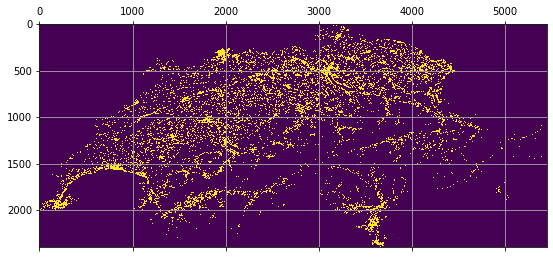

<Figure size 432x288 with 0 Axes>

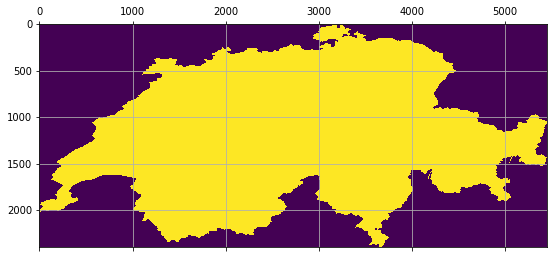

In [200]:
plot_2dmatrix(b1)
plot_2dmatrix(b2)

In [201]:
with rio.open("/scratch3/ldominiak/luca_pomelo_input_data/CHE/merged_CHE.tif", 'r') as tmp:
    metadata_CH = tmp.meta.copy()
metadata_CH

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -99999.0,
 'width': 5447,
 'height': 2397,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00083333333, 0.0, 5.956249991169982,
        0.0, -0.00083333333, 47.81458334344999)}

In [202]:
with rio.open("/scratch3/ldominiak/luca_pomelo_input_data/CHE/CHE_Covariates/che_dst_bsgme_100m_2015.tif", 'r') as tmp:
    meta_test = tmp.meta.copy()
meta_test

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -99999.0,
 'width': 5447,
 'height': 2397,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00083333333, 0.0, 5.956249991169982,
        0.0, -0.00083333333, 47.81458334344999)}

In [191]:

# specify the source file and destination directory
src_file = "/scratch3/ldominiak/luca_pomelo_input_data/CHE/merged_CHE.tif"
dst_dir = "/scratch3/ldominiak/luca_pomelo_input_data/CHE/CHE_Covariates/che_merged_CHE_buildings_final.tif"

# move the file
shutil.move(src_file, dst_dir)

'/scratch3/ldominiak/luca_pomelo_input_data/CHE/CHE_Covariates/che_merged_CHE_buildings_final.tif'

<Figure size 432x288 with 0 Axes>

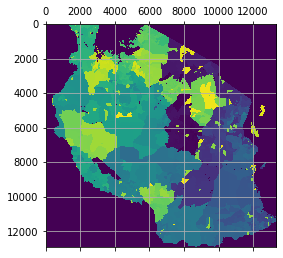

In [5]:
test = '/scratch3/ldominiak/luca_pomelo_input_data/TZA/admin_regions/tza_wp_admin_regions.tif'

data_new = gdal.Open(test)
band_1_1 = data_new.GetRasterBand(1)
b1_1 = band_1_1.ReadAsArray() 

plot_2dmatrix(b1_1)

In [5]:
shape_path = "/scratch3/ldominiak/luca_pomelo_input_data/CHE/merged_CHE.shp"
gdf = gpd.read_file(shape_path)

gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [40]:
# define image metadata
pixel_size = 0.00083333333

path = "/scratch3/ldominiak/luca_pomelo_input_data/CHE/CHE_Covariates/che_dst_bsgme_100m_2015.tif"
with rio.open(path) as src:
    # read the spatial information
    left, bottom, right, top = src.bounds

x_res = int(round((right - left) / pixel_size))
y_res = int(round((top - bottom) / pixel_size))


In [41]:
raster_data = np.zeros((y_res, x_res), dtype='float32')

In [42]:
for idx, row in gdf.iterrows():
    x,y = row['geometry'].centroid.coords[0]
    col = int((x - left) / pixel_size)
    row = int((top - y) / pixel_size)
    raster_data[row, col] += 1

In [43]:
with rio.open("/scratch3/ldominiak/luca_pomelo_input_data/CHE/CHE_Covariates/che_esaccilc_dst_water_100m_2000_2012.tif", 'r') as tmp:
    meta_test = tmp.meta.copy()


In [52]:
profile = {
    'driver': 'GTiff',
    'dtype': meta_test['dtype'],
    'nodata': -99999.0,
    'count': 1,
    'width': x_res,
    'height': y_res,
    'crs': CRS.from_epsg(4326),
    'transform': rio.transform.from_bounds(left, bottom, right, top, x_res, y_res),
}

In [53]:
output_file = "/scratch3/ldominiak/luca_pomelo_input_data/CHE/CHE_Covariates/che_merged_CHE_buildings_final_new.tif"

with rio.open(output_file, 'w', **profile) as dist:
    dist.write(raster_data, 1)

In [54]:
with rio.open("/scratch3/ldominiak/luca_pomelo_input_data/CHE/CHE_Covariates/che_merged_CHE_buildings_final_new.tif", 'r') as tmp:
    meta_test = tmp.meta.copy()
meta_test

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -99999.0,
 'width': 5447,
 'height': 2397,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00083333333, 0.0, 5.956249991169982,
        0.0, -0.0008333333299999996, 47.81458334344999)}

In [56]:
with rio.open("/scratch3/ldominiak/luca_pomelo_input_data/TZA_covariates/tza_gbuildings.tif", 'r') as tmp:
    meta_test = tmp.meta.copy()
meta_test

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 13342,
 'height': 12916,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00083333333, 0.0, 29.327083231019998,
        0.0, -0.00083333333, -0.9820831280299984)}